<a href="https://colab.research.google.com/github/shikharmay7/Go-Corona/blob/master/face_mask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [12]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


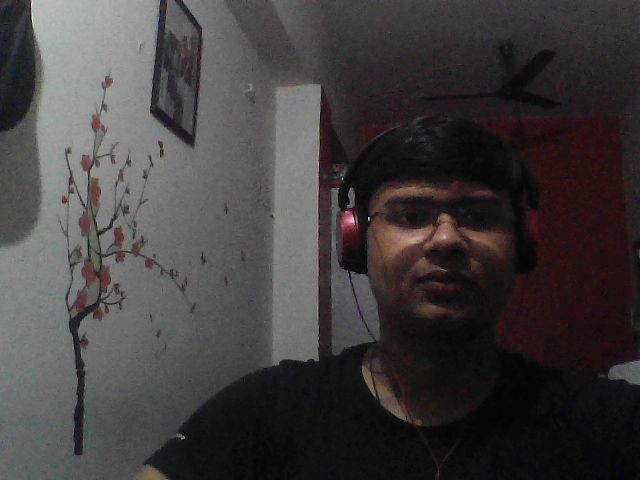

In [13]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [14]:
import cv2
import numpy as np

face_clsfr=cv2.CascadeClassifier('cascades/data/haarcascade_frontalface_default.xml')

labels_dict={0:'without_mask',1:'with_mask'}
color_dict={0:(0,0,255),1:(0,255,0)}

size = 4
cap = cv2.VideoCapture(0) #Use camera 0

# We load the xml file
#classifier = cv2.CascadeClassifier('cascades/data/haarcascade_frontalface_default.xml')

while True:
    ret, img = cap.read()
    #im=cv2.flip(im,1,1) #Flip to act as a mirror
    # Resize the image to speed up detection
    #mini = cv2.resize(im, (im.shape[1] // size, im.shape[0] // size))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY )  
    faces = face_clsfr.detectMultiScale(gray,1.3,5)

    for (x,y,w,h) in faces:
        cv2.rectangle(img, (x,y), (x+w, y+h), (255,0,0), 2)
    # Draw rectangles around each face
    #for f in faces:
        #(x, y, w, h) = [v * size for v in f] #Scale the shapesize backup
        #Save just the rectangle faces in SubRecFaces
        #face_img = img[y:y+h, x:x+w]
        #resized=cv2.resize(face_img,(150,150))
        #normalized=resized/255.0
        #reshaped=np.reshape(normalized,(1,150,150,3))
        #reshaped = np.vstack([reshaped])
        #result=model.predict(reshaped)
        #print(result)
        
        #label=np.argmax(result,axis=1)[0]
        #label=1 
        #cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        #cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        #cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
    # Show the image
    cv2.imshow('LIVE',   img)
    key = cv2.waitKey(10)
    # if Esc key is press then break out of the loop 
    if key == 27: #The Esc key
        break
# Stop video
cap.release()
cv2.destroyAllWindows()



error: ignored

In [38]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd
from os import listdir
import cv2
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from keras.models import Model, load_model, Sequential
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import imutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
from keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split


In [18]:
X=[]
y=[]
base_path1 = '/content/drive/My Drive/Datasets/mask-data/with_mask/'
for i in os.listdir(base_path1):
  img = load_img(base_path1 + str(i), target_size=(224,224))
  img  = img_to_array(img)
  img = preprocess_input(img)
  X.append(img)
  y.append([1,0])

base_path2 = '/content/drive/My Drive/Datasets/mask-data/without_mask/'
for i in os.listdir(base_path2):
  img = load_img(base_path2 + str(i), target_size=(224,224))
  img = img_to_array(img)
  img = preprocess_input(img)
  X.append(img)
  y.append([0,1])

data = np.array(X)
labels = np.array(y)




In [33]:
(X_train, X_test, y_train, y_test) = train_test_split(data, labels, test_size=0.20, random_state=42)

In [34]:
print(len(X), len(X_train), len(X_test))


1376 1100 276


In [39]:
model = Sequential()
mobnet = MobileNet()

for layer in range(len(mobnet.layers)-1):
  model.add(mobnet.layers[layer])

for layer in model.layers[:-9]:
  layer.trainable=False

model.add(Dense(2, activation='softmax'))

In [40]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)     

In [41]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [43]:
model.save('face_mask_det.h5')
#mod1 = load_model('face_mask_det.h5')

In [44]:
hist = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.1)

Train on 990 samples, validate on 110 samples
Epoch 1/20
990/990 [==============================] - 76s 76ms/step - loss: 0.4559 - accuracy: 0.9505 - val_loss: 0.4360 - val_accuracy: 0.9545
Epoch 2/20
990/990 [==============================] - 74s 75ms/step - loss: 0.1710 - accuracy: 0.9818 - val_loss: 0.1394 - val_accuracy: 0.9909
Epoch 3/20
990/990 [==============================] - 75s 75ms/step - loss: 0.1257 - accuracy: 0.9879 - val_loss: 0.1394 - val_accuracy: 0.9909
Epoch 4/20
990/990 [==============================] - 75s 76ms/step - loss: 0.0908 - accuracy: 0.9919 - val_loss: 1.7340e-08 - val_accuracy: 1.0000
Epoch 5/20
990/990 [==============================] - 75s 76ms/step - loss: 0.0525 - accuracy: 0.9949 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/20
990/990 [==============================] - 75s 76ms/step - loss: 0.0155 - accuracy: 0.9990 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/20
990/990 [==============================] - 75s 75ms/step - loss: 0.

KeyboardInterrupt: ignored

In [45]:
model.evaluate(X_test, y_test)

276/276 [==============================] - 20s 71ms/step


[0.8454572204230488, 0.9239130616188049]

In [54]:
model.save('face_mask_det1.h5')

In [52]:
labels_dict={0:'without_mask',1:'with_mask'}
color_dict={0:(0,0,255),1:(0,255,0)}

size = 4
webcam = cv2.VideoCapture(0) #Use camera 0

# We load the xml file
classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

while True:
    rval, im = webcam.read()
    im=cv2.flip(im,1,1) #Flip to act as a mirror
    # Resize the image to speed up detection
    mini = cv2.resize(im, (im.shape[1] // size, im.shape[0] // size))

    # detect MultiScale / faces 
    faces = classifier.detectMultiScale(mini)

    # Draw rectangles around each face
    for f in faces:
        (x, y, w, h) = [v * size for v in f] #Scale the shapesize backup
        #Save just the rectangle faces in SubRecFaces
        face_img = im[y:y+h, x:x+w]
        resized=cv2.resize(face_img,(224,224))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,224,224,3))
        reshaped = np.vstack([reshaped])
        result=model.predict(reshaped)
        #print(result)
        
        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(im,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(im,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(im, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
    # Show the image
    cv2.imshow('LIVE',   im)
    key = cv2.waitKey(10)
    # if Esc key is press then break out of the loop 
    if key == 27: #The Esc key
        break
# Stop video
webcam.release()

# Close all started windows
cv2.destroyAllWindows()

AttributeError: ignored